In [1]:
# Loading in libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import os
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import similaritymeasures

# Importing helper libraries 
from dependencies.data_preprocessing_class import dataPreprocessing
from dependencies.gaussian_process_regression_class import gaussianProcessRegression
from dependencies.acquisition_functions_class import acqisitionFunctions
from dependencies.geometry_writer import geometryWriter
from dependencies.feature_extractor_4 import FeatureExtractor

## 1. Preparing output feature space for sensitivity analysis 

1. For comptation of sensitivity, simulations are run by increasing and decreasing parameter values by 70% for each individual parameter of the surface evolver model using master_sensitivity_analysis.py. The input parameters of the model ($ \theta $) and the output shape features of the surface evolver simulations ($ S(\theta), x $) are organized within numpy array as shown within the schematic below. x represents the initial condition i.e. the initial geometry from which the simulation starts in our case.   

!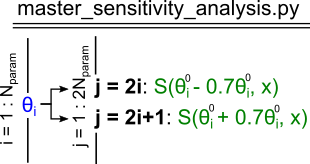

2. Following parameters within the model were varied during sensitivity analysis
    - $T^{squ}_{B}$, $T^{cub}_{B}$, $T^{col}_{B}$, $k^{squ}_{A}$, $k^{squ}_{B}$, $k^{squ}_{L}$, $k^{cub}_{A}$, $k^{cub}_{B}$, $k^{cub}_{L}$, $k^{col}_{A}$, $k^{col}_{B}$, $k^{col}_{L}$, $Lo^{squ}_{A}$, $Lo^{squ}_{B}$, $Lo^{squ}_{L}$, $Lo^{cub}_{A}$, $Lo^{cub}_{B}$,$Lo^{cub}_{L}$, $Lo^{col}_{A}$, $Lo^{col}_{B}$, $Lo^{col}_{L}$, $K_{ECM}$


3. For each simulation run we record the following morphologocal features as outputs
    - Edge length of individual components ('output_data_files/tissue_edge_length_master.npy')
    - local curvature extimated at each vertex on the basal surface ('output_data_files/curvature_basal_master.npy')
    - frechet error measuring deviation of apical and basl surface from the equilibrium tissue shape ('output_data_files/error_target_sampled_apical.npy, error_target_sampled_basal.npy')


4. Reduction of dimensionality of original morphological features into meaningful biologocal features, ($ S(\theta), x $)
    - Converting edge length matrix into eaningful measurable wing disc cell lengths of different subtypes.
        - $L^{col}_{A}$, $L^{col}_{B}$, $L^{col}_{L}$, $L^{cub}_{A}$, $L^{cub}_{B}$, $L^{cub, col}$, $L^{cub}_{L}$, $L^{squ}_{A}$, $L^{squ}_{B}$, $L^{squ, cub}$, $L^{squ}_{L}$
    - Averaging curvature to approximate the curvature of basal surface near the center and anterior/posterior ends.
        - $\kappa_{Posterior}$, $\kappa_{Anterior}$, $\kappa_{Central}$
    - Frechet error measuring deviation of apical and basl surface from the equilibrium tissue shape
        - $F_{A}$, $F_{B}$

In [2]:
"""  Step 1: Reducing dimensionality of edge length feature
Inputs:
     i) output_data_files/tissue_edge_length_master: edge lengths of all the cells for samples from parameter screen. It is a 
                                                     [n_total x 390] array
     ii) edge_length_identity.xlsx: Each of the 390 edge lengths belong to a specific cell type class. The array 
                                    contains 390 labels for each edge type
 
Output: 
     i) tissue_edge_length_t : The edge lengths are trucated as mean values of edge lengths belonging to a 
                               particular calss of cell type. Its a [n_total x 11] array. We have a total of 
                               11 different cell edge types  """

# Defining the total number of simulations (= 2 x number of parameters)
n_simulation = 44
# Reading the excel sheet containiing identity of all the 390 cell types as a dataframe
df_identity = pd.read_excel ('edge_length_identity.xlsx')
# Loading the master data containing edge lengths in columns (390) for all the samples in row
tissue_edge_length_master = np.load('output_data_files/tissue_edge_length_master.npy')
# Labels for individual edge length types
edge_length_labels = ('$L^{col}_{A}$', '$L^{col}_{B}$', '$L^{col}_{L}$', '$L^{cub}_{A}$', '$L^{cub}_{B}$', 
                      '$L^{cub, col}$', '$L^{cub}_{L}$', '$L^{squ}_{A}$', '$L^{squ}_{B}$', '$L^{squ, cub}$',
                      '$L^{squ}_{L}$')         
# Initializing truncated edge length array
tissue_edge_length_t = np.zeros((n_simulation,11))
# Iterating through each sample to truncate the edge lengths
for i in range(n_simulation):
    # edge length for the nth sample
    iter_edge_length = tissue_edge_length_master[i,:]
    # reshaping the array as a column array for truncation
    iter_edge_length_r = np.reshape(iter_edge_length,(390,1))
    # creating two data frames of edge lengths and their identities
    df_edge_length = pd.DataFrame(iter_edge_length_r, columns = ['SE_edge_length'])
    df_iter = pd.concat([df_identity, df_edge_length], axis=1)
    # Use the grouping feature of dataframes to compute mean edge length for each cell type
    x = df_iter.groupby('identity').mean().values
    # Storing the truncated values in master truncated edge length rray
    tissue_edge_length_t[i,:] = np.reshape(x,(1,11))

"""  Step 2: Reducing dimensionality of basal curvature feature

Inputs: 
    i) output_data_files/curvature_basal_master: An array of shape [n_samples x n_basal_points] containing 
                                                local curvature of the basal epithelia
Outputs: 
    ii) curvature_basal_t :  Average basal curvature for columnar tissue computed at the medial and lateral ends.
                             Shape - [n_samples x 3] """

# Loading the array containing curvature data from the sensitivity screening
curvature_basal_master = np.load('output_data_files/curvature_basal_master.npy')
# Extracting the curvature of the bsala columnar epithelia
curvature_basal_master_columnar = curvature_basal_master[:,16:116]
# Initializing the array theat will store the truncated average curvature within the basal epithelia
curvature_basal_t = np.zeros((n_simulation,3))
# Extracting curvature values of three equal domains representing the medial basal and two mlateral basal domains
curv_right = curvature_basal_master_columnar[:,0:25]
curv_center = curvature_basal_master_columnar[:,25:75]
curv_left = curvature_basal_master_columnar[:,75:100]
# Computing average curvature values for the three domains
curv_right_average = np.mean(curv_right, axis = 1)
curv_center_average = np.mean(curv_center, axis = 1)
curv_left_average = np.mean(curv_left, axis = 1)
# Storing the truncated currvatures in masater array
curvature_basal_t[:,0] = curv_right_average 
curvature_basal_t[:,1] = curv_center_average
curvature_basal_t[:,2] = curv_left_average


"""  Step 3: Loading frechet error for upper and lower parameter bounds for the apical and basal surfaces  """

error_target_sampled_apical = np.load('output_data_files/error_target_sampled_apical.npy')
error_target_sampled_basal = np.load('output_data_files/error_target_sampled_basal.npy')

## 2. Computing sensitivities for different features

1. Finite difference method (Cenytral difference formulae) was used to compute sensitivities
    - $  \dot{S_{i}}  = \frac{S(\theta^{+}_{i}, x) - S(\theta^{-}_{i}, x)}{\theta^{+}_{i} - \theta^{-}_{i}} $ where,
    - $ \dot{S_{i}}$ denotes the sensitivity in shape features upon varying the $i^{th}$ parameter 
    - $\theta^{+}_{i}, \theta^{-}_{i}$: $i^{th}$ parameter was increased and decreased by 70% in our study.

In [3]:
"""
This portion of the code computes sensitivitiy in shape features upon variation of model parameters using
the finite difference formulae. 
Sensitivity can be compued using two different ways based on the choice of calc_method parameter.

Input: 
    - calc_method == (1,2,3) : 1=> Actual change in parameter values is used. 
                               2=> The change in the parameter values is normalized against the equilibrium parameter value
                               3=> Logscale of deinator in method 2

Output:
    - sens_frechet_apical (n_param x 1) :  Sensitivity in overall shape changes across pouch apical surface
    - sens_frechet_basal (n_param x 1): Sensitivity in overall shape changes across pouch basal surface
    - sens_curv (n_param x 3): Sensitivity in basal curvature of the epithelial calculated across medial, anterior and posterior domains
    - sens_cell_length (n_param x 11): Sensitivity in cell lengths pf different cell types
"""
# Define the calculation method for denominator of the sensitivity
calc_method = 3
# number of parameters varied
n_param = 22
# param values around equilibrium
val_param = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# Initialization of arrays to store sensitivities in features upon perturbation of parameters
sens_frechet_apical = np.zeros((n_param,))
sens_frechet_basal = np.zeros((n_param,))
sens_curv = np.zeros((n_param,3))
sens_cell_length = np.zeros((n_param,11))

# Calculating sensitivities for different parameters using the formulae above
for i in range(22):
    # Defining choice of sensitivity calculation
    if calc_method == 1:
        d_theta = 0.7*param_val[i]
    elif calc_method == 2:
        d_theta = 0.7
    elif calc_method == 3:
        d_theta = np.log(1.7)
    # Calculating sensitivities
    sens_frechet_apical[i] = (error_target_sampled_apical[2*i + 1] - error_target_sampled_apical[2*i]) / (2*d_theta)
    sens_frechet_basal[i] = (error_target_sampled_basal[2*i + 1] - error_target_sampled_basal[2*i]) / (2*d_theta)
    sens_curv[i,:] = np.subtract(curvature_basal_t[2*i+1,:], curvature_basal_t[2*i,:]) / (2*d_theta)
    sens_cell_length[i,:] = np.subtract(tissue_edge_length_t[2*i+1,:], tissue_edge_length_t[2*i,:]) / (2*d_theta)

### 2.1 Bar graph for visualizing sensitivies. 

Text(0.5,0.95,'$f$')

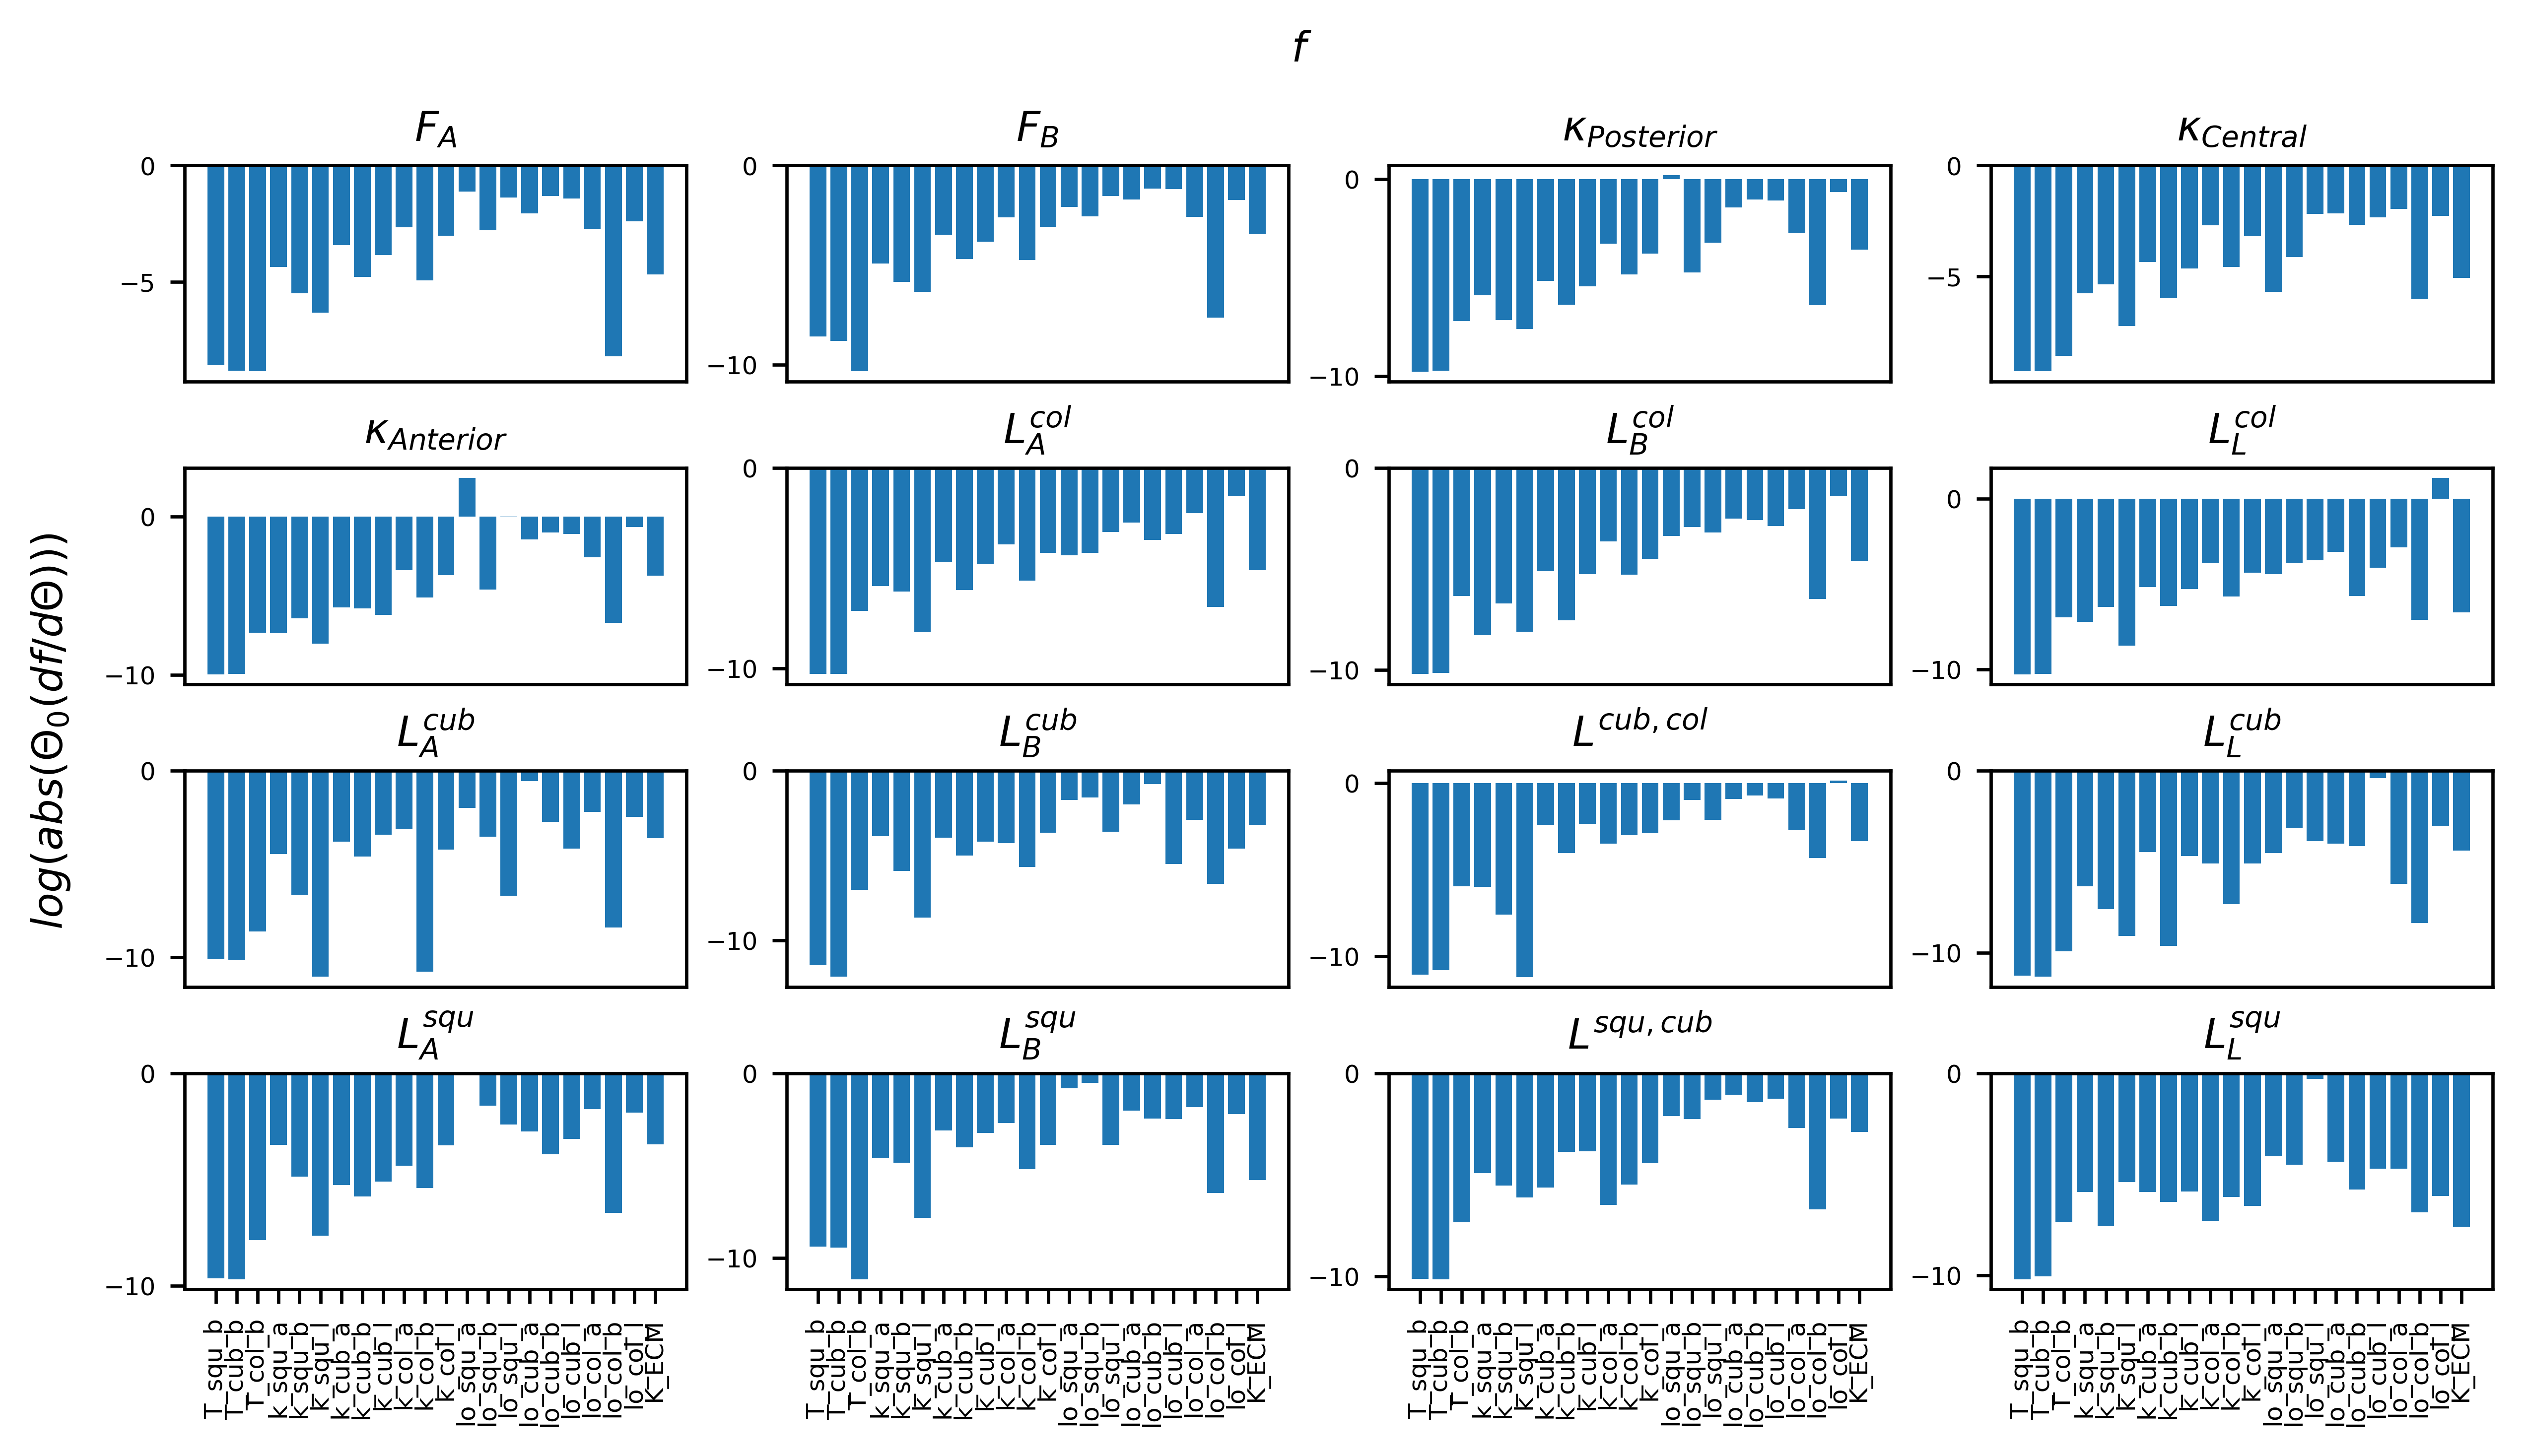

In [4]:
# List of parameters in the sampling for screening    
params_lhs = ('T_squ_b','T_cub_b','T_col_b','k_squ_a','k_squ_b','k_squ_l','k_cub_a','k_cub_b','k_cub_l','k_col_a','k_col_b','k_col_l','lo_squ_a','lo_squ_b','lo_squ_l','lo_cub_a','lo_cub_b','lo_cub_l','lo_col_a','lo_col_b','lo_col_l','K_ECM')
# Defining the size (figsize) and resolution (dpi) of figure
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(10, 5), dpi=600)

"""  Step 1: Plotting sensitivity in Frechet errors  """

# Positioning the bars at equal intervals. Number of bars for each subplot
# equals the number of parameters that were varied.
y_pos = np.arange(len(params_lhs))
# Subplot 1: Sensitivity in apical frechet error
plt.subplot(4, 4, 1)
# Using matplotlib to plot sensitivities for frechet error apical in define positions on the x axis
plt.bar(y_pos, np.log(np.abs(sens_frechet_apical)))
# Turing off ticks in the scale
plt.xticks([])
# Changing the fontsize of y axis
plt.yticks(fontsize=6)
# Defining title of the plot representing the feature for which sensitivityt was measured
plt.title('$F_{A}$', fontsize=10)
# Subplot 1: Sensitivity in basal frechet error
plt.subplot(4, 4, 2)
plt.bar(y_pos, np.log(np.abs(sens_frechet_basal)))
plt.xticks(y_pos, params_lhs)
plt.xticks([])
plt.yticks(fontsize=6)
plt.title('$F_{B}$', fontsize=10)

"""  Step 2: Plotting sensitivity in curvatures  """

# Subplot 3
plt.subplot(4, 4, 3)
plt.bar(y_pos, np.log(np.abs(sens_curv[:,0])))
plt.xticks([])
plt.yticks(fontsize=6)
plt.title('$\kappa_{Posterior}$', fontsize=10)
# Subplot 4
plt.subplot(4, 4, 4)
plt.bar(y_pos, np.log(np.abs(sens_curv[:,1])))
plt.xticks(y_pos, params_lhs)
plt.xticks([])
plt.yticks(fontsize=6)
plt.title('$\kappa_{Central}$',fontsize=10)
# Subplot 5
plt.subplot(4, 4, 5)
plt.bar(y_pos, np.log(np.abs(sens_curv[:,2])))
plt.xticks(y_pos, params_lhs)
plt.xticks([])
plt.yticks(fontsize=6)
plt.title('$\kappa_{Anterior}$',fontsize=10)

"""  Step 3: Plotting sensitivity in cell height  """

for i in range(11):
    if i < 7:
        plt.subplot(4, 4, 5+i+1)
        plt.bar(y_pos, np.log(np.abs(sens_cell_length[:,i])))
        plt.xticks([])
        plt.yticks(fontsize=6)
        plt.title(edge_length_labels[i], fontsize=10)
    # Printing x labels in the bar plots of last row
    elif i >= 7:
        plt.subplot(4, 4, 5+i+1)
        plt.bar(y_pos, np.log(np.abs(sens_cell_length[:,i])))
        plt.xticks(y_pos, params_lhs)
        plt.xticks(rotation = 90)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.title(edge_length_labels[i], fontsize=10)
    
"""  Final figure adjustments  """

# Making the spaces between the subplots uniform
plt.subplots_adjust(hspace=0.4)
# Deining the label of y axis for all the sublots. Placing it in the left hand side of the figure.
fig.text(0.073, 0.5, '$log(abs(\Theta_{0}(df/d\Theta)))$', va='center', rotation='vertical')
fig.text(0.5, 0.95, '$f$', ha='center')

__Figure 1: Barplots describing sensitivities of all the measured geometrical features upon perturbation of model parameters.__  A total of 16 geometrical features whose sensitivity is measures are listed as heading of each subplot. Labels in the x axis of each plot represent the model parameters that were varied against which the sensitivity was cmputed.*Note: Log of absolute value of sensitivity has been plotted*

### 2.2 Heatmap for visualizing sensitivity

Text(0.5,28.9333,'$Output - S(\\Theta, x)$')

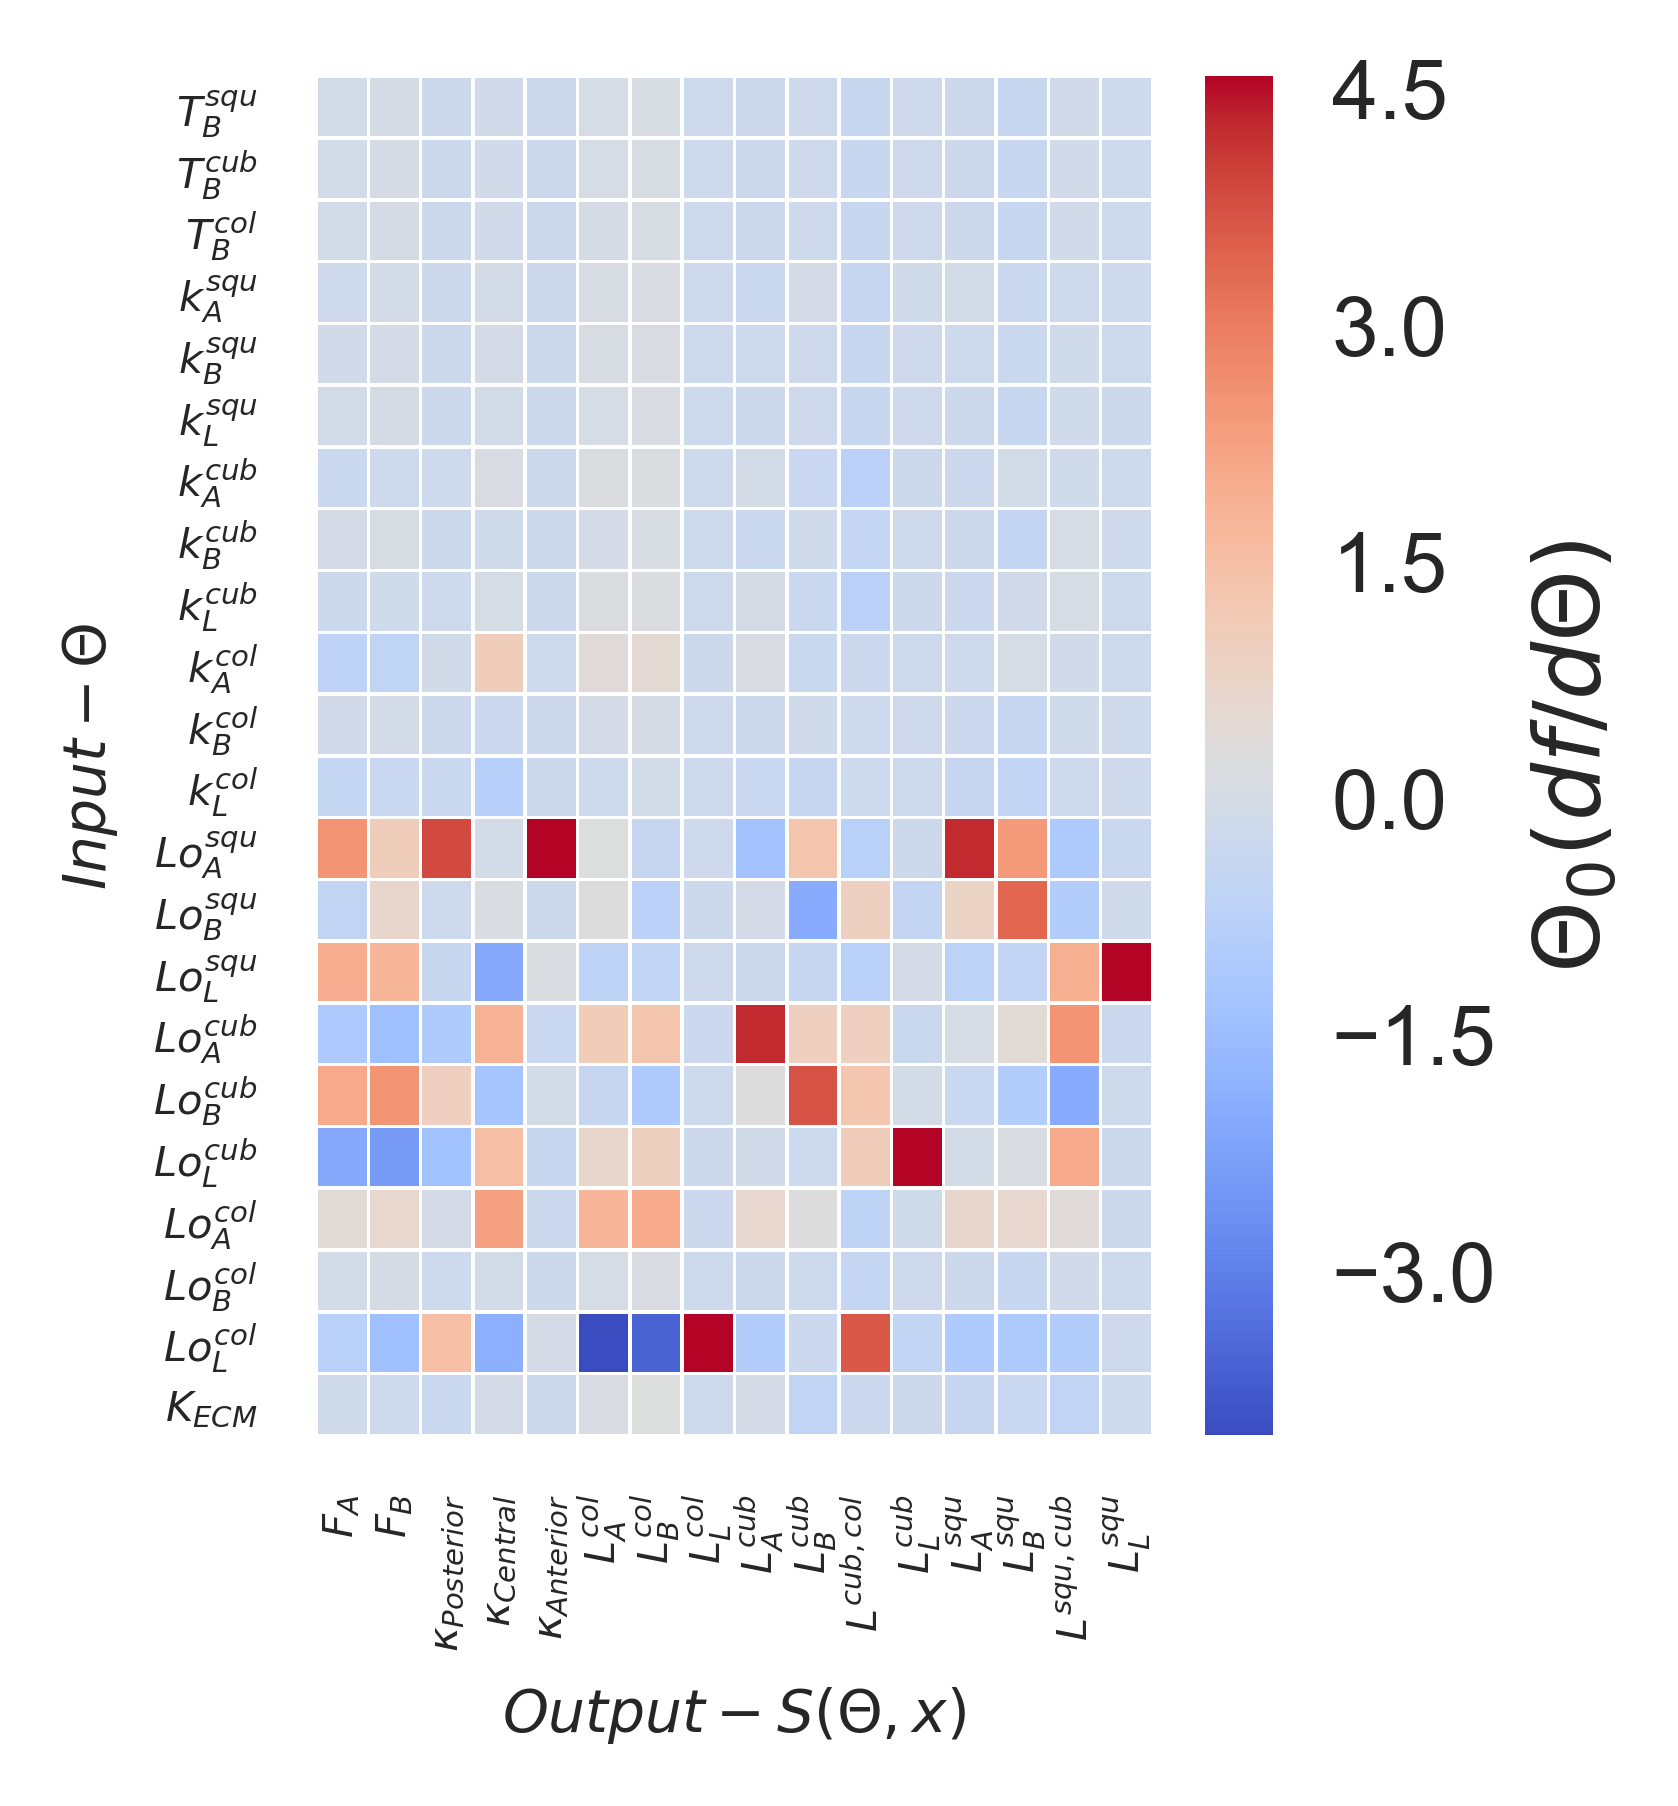

In [5]:
# Creating the master sensitivity matrix by horizontally concatenating each column representing a particular geometrical feature .
sens_master = np.hstack((np.reshape(sens_frechet_apical,(22,1)),np.reshape(sens_frechet_basal,(22,1)),sens_curv, sens_cell_length))
# Scaling the sensitivity wrt to mean 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sens_master_scaled = sc.fit_transform(sens_master)

""" Plotting """
# Importing seaborn for visualization of the sensitivity array
import seaborn as sns
# Defining labels of features and parameters
x_label = ('$F_{A}$','$F_{B}$')+('$\kappa_{Posterior}$','$\kappa_{Central}$','$\kappa_{Anterior}$')+ edge_length_labels
params_lhs = ('$T^{squ}_{B}$','$T^{cub}_{B}$','$T^{col}_{B}$','$k^{squ}_{A}$','$k^{squ}_{B}$','$k^{squ}_{L}$','$k^{cub}_{A}$','$k^{cub}_{B}$','$k^{cub}_{L}$','$k^{col}_{A}$','$k^{col}_{B}$','$k^{col}_{L}$','$Lo^{squ}_{A}$','$Lo^{squ}_{B}$','$Lo^{squ}_{L}$','$Lo^{cub}_{A}$','$Lo^{cub}_{B}$','$Lo^{cub}_{L}$','$Lo^{col}_{A}$','$Lo^{col}_{B}$','$Lo^{col}_{L}$','$K_{ECM}$')
# Defining the resolution of the figure
sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
# Defining the size of figure
sns.set(rc={'figure.figsize':(2.25,3)})
# Using seaborn to plot visualize the array as a heatmap
ax = sns.heatmap((sens_master_scaled), xticklabels = x_label, yticklabels = params_lhs, linewidths=.3, cmap="coolwarm", cbar_kws={'label': '$\Theta_{0}(df/d\Theta)$'})
# Labelling the axes
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 5)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
ax.set_ylabel('$Input - \Theta$', fontsize=7)
ax.set_xlabel('$Output - S(\Theta, x)$', fontsize=7)

__Figure 2: Plotting heatmaps of sensitivities.__ *Notes: __(A)__ A master sensitivity array is defined where evry column represents sensitivity in a particular feature (row). Each row     represents the total parameters that were varied during the sensitivity analysis. Shape [n_param x n_feature] __(B)__ Scaled and non-scaled senitivities are plotted*

## 3. Computing and visualizing Fischer Information matrices

1. This analysis has to be disregarded for Frechet errors. For all other features except $F_{A}, F_{B}$ a least square objective function is used to define the error. Hence the local curvature or Hessian (H) can be written as $J.J^{T}$ i.e. 
    - $H(\theta ,x) = \dot{S(\theta ,x)}\dot{S(\theta ,x)}^{T}$
    - $\theta = 22$  : $T^{squ}_{B}$, $T^{cub}_{B}$, $T^{col}_{B}$, $k^{squ}_{A}$, $k^{squ}_{B}$, $k^{squ}_{L}$, $k^{cub}_{A}$, $k^{cub}_{B}$, $k^{cub}_{L}$, $k^{col}_{A}$, $k^{col}_{B}$, $k^{col}_{L}$, $Lo^{squ}_{A}$, $Lo^{squ}_{B}$, $Lo^{squ}_{L}$, $Lo^{cub}_{A}$, $Lo^{cub}_{B}$, $Lo^{cub}_{L}$, $Lo^{col}_{A}$, $Lo^{col}_{B}$, $Lo^{col}_{L}$, $K_{ECM}$
    - $S = 16$: $F_{A}$, $F_{B}$, $\kappa_{Posterior}$',$\kappa_{Central}$,$\kappa_{Anterior}$, $L^{col}_{A}$, $L^{col}_{B}$, $L^{col}_{L}$, $L^{cub}_{A}$, $L^{cub}_{B}$, $L^{cub, col}$, $L^{cub}_{L}$, $L^{squ}_{A}$', $L^{squ}_{B}$, $L^{squ, cub}$', $L^{squ}_{L}$


2. Steps followed:
    - For each morphological feature k jacobian ($J(\theta)$) is defined $n_{\theta}$ x 1 shaped column array defined by $\dot{S^{k}(\theta ,x)}$.
    - Hessian ($H(\theta)$) is approximated as $J(\theta)J(\theta)^{T}$ and is of the dimension $n_{\theta}$ x $n_{\theta}$
    - The matrix is symmetric hence *np.linalg.eigh* is used to compute the eigenvalues and eigenvectors
    - Note: $H(\theta)$ is scaled by square of standard deviation of the $J(\theta)$

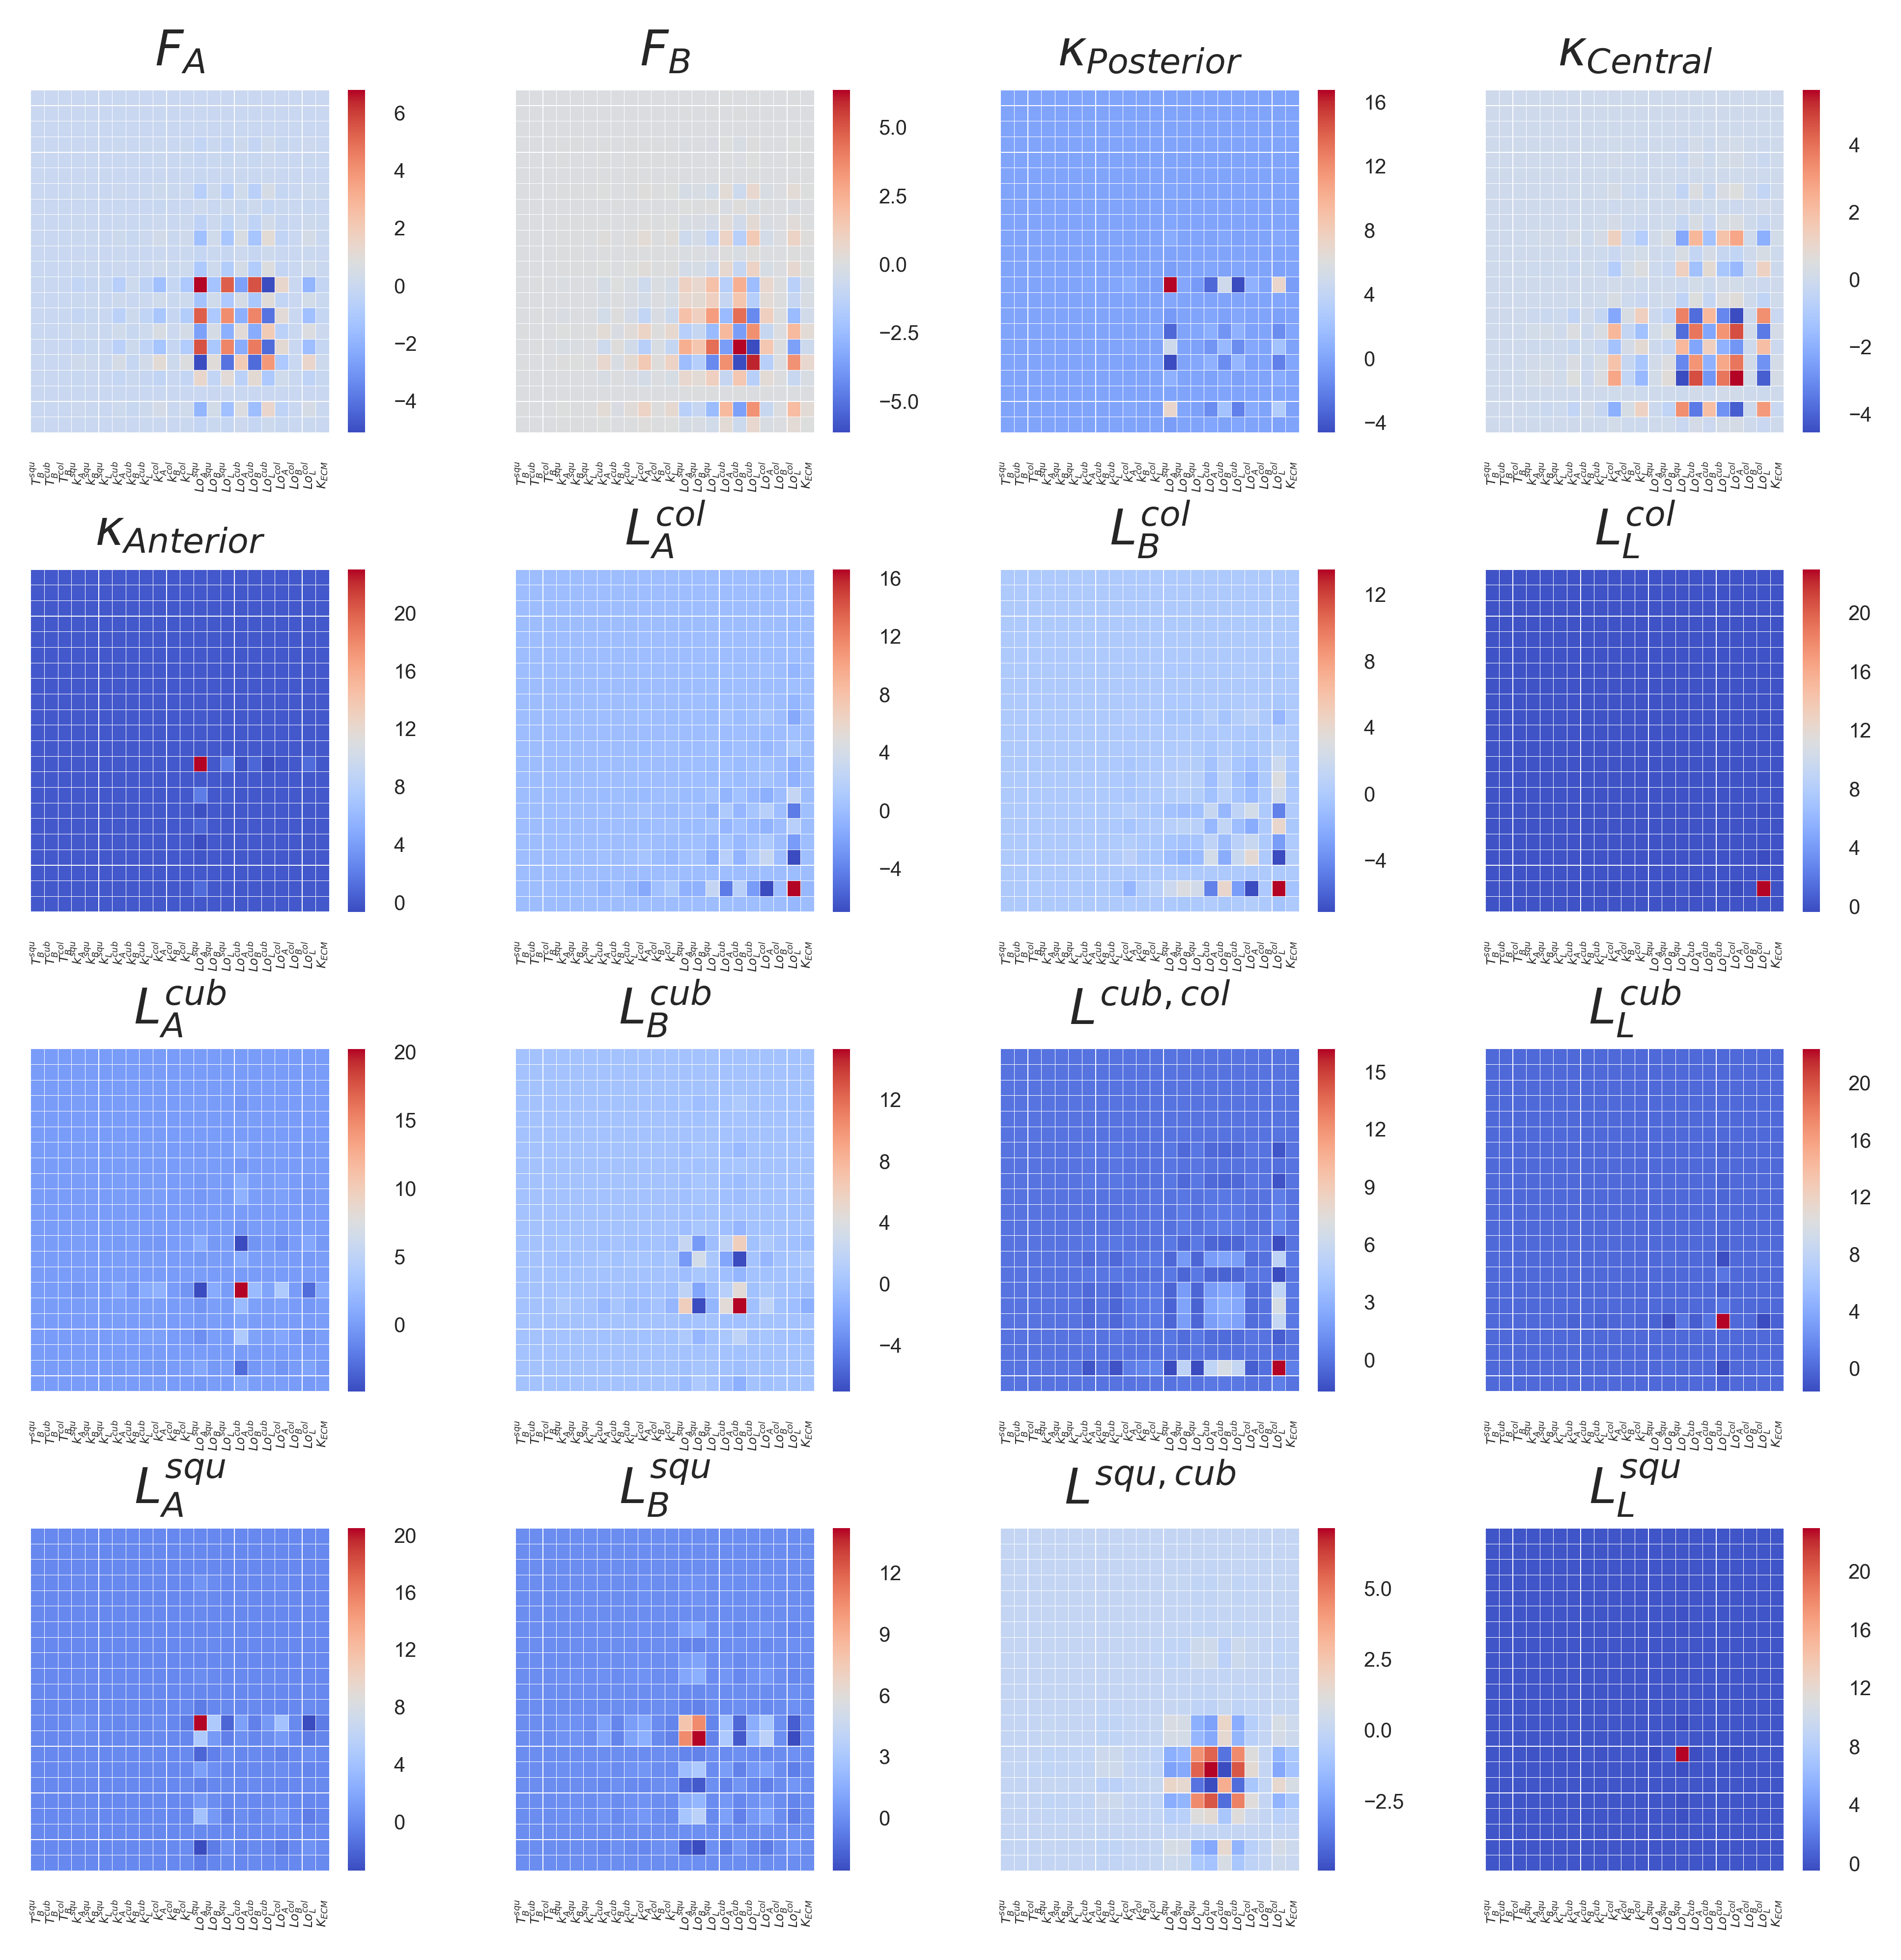

In [6]:
"""
This portion of the code calculates the Hessian for all the geometrical features

"""

# Importing linear algebra modele from numpy
from numpy import linalg

# Defining the number of parameters and number of features in the study
num_param = 22
num_feature = 16

# Storing real and complex part of eigenvalues to ensure correctness in eigenvalue calculations
fim_eig_real = np.zeros((num_feature,num_param))
fim_eig_complex = np.zeros((num_feature,num_param))

# Defining properties of figures 
fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharey=True, dpi=600)
# Initializing counter
k = 0

# Loop over all  the jacobians of inmdividual features
for i in range(4):
    for j in range(4):
        # Fetching jacobian of individual features from the master sensitivity matrix
        jacobian_feature = np.reshape(sens_master[:,k],(num_param,1))
        # calculate fischer information matrix
        # Note: Scaling wrt variance of jacobian has been done
        fim_feature = np.matmul(jacobian_feature,jacobian_feature.transpose())/((np.std(jacobian_feature))**2)
        # Calculate eigenvalue and eigenvectors of the symmetric matrix using eigh
        fim_eigvalue, fim_eigenvector = np.linalg.eigh(fim_feature)
        # Calculating the real part of eigenvalue
        fim_eig_real[k,:] = np.reshape((np.real(fim_eigvalue)),(1,num_param))
        # Calculating the complex part of the eigenvalue
        fim_eig_complex[k,:] = np.reshape((np.imag(fim_eigvalue)),(1,num_param))
        # Plotting FIMs as heatmaps using seaborn
        hmap = sns.heatmap(fim_feature, xticklabels = params_lhs, yticklabels = params_lhs, linewidths=.02, cmap="coolwarm",ax=axes[i,j])
        # Setting up the plot titles as the features for which FIM has been calculated
        axes[i,j].set_title(x_label[k])
        # Adding colorbar
        cbar = hmap.collections[0].colorbar
        # Setting up the labelsizes
        cbar.ax.tick_params(labelsize=5)
        # Setting up fornts for xtick and yticklabels
        hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize = 3)
        hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize = 3)
        # Increasing the counter. Moving to th enxt feature
        k = k + 1
        
# Increasing spacing between the subplots 
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)

__Figure 3: Plotting approximated FIM of different geometric features__ *Note: The morphological featre for which the FIM has been computed has been mentioned as a title in the plot.*

### 3.1 Bar graph visualization of eigenvalues corresponding to hessian of each measurable features

Text(0.5,0.95,'$Measurable$  $morphological$  $features$')

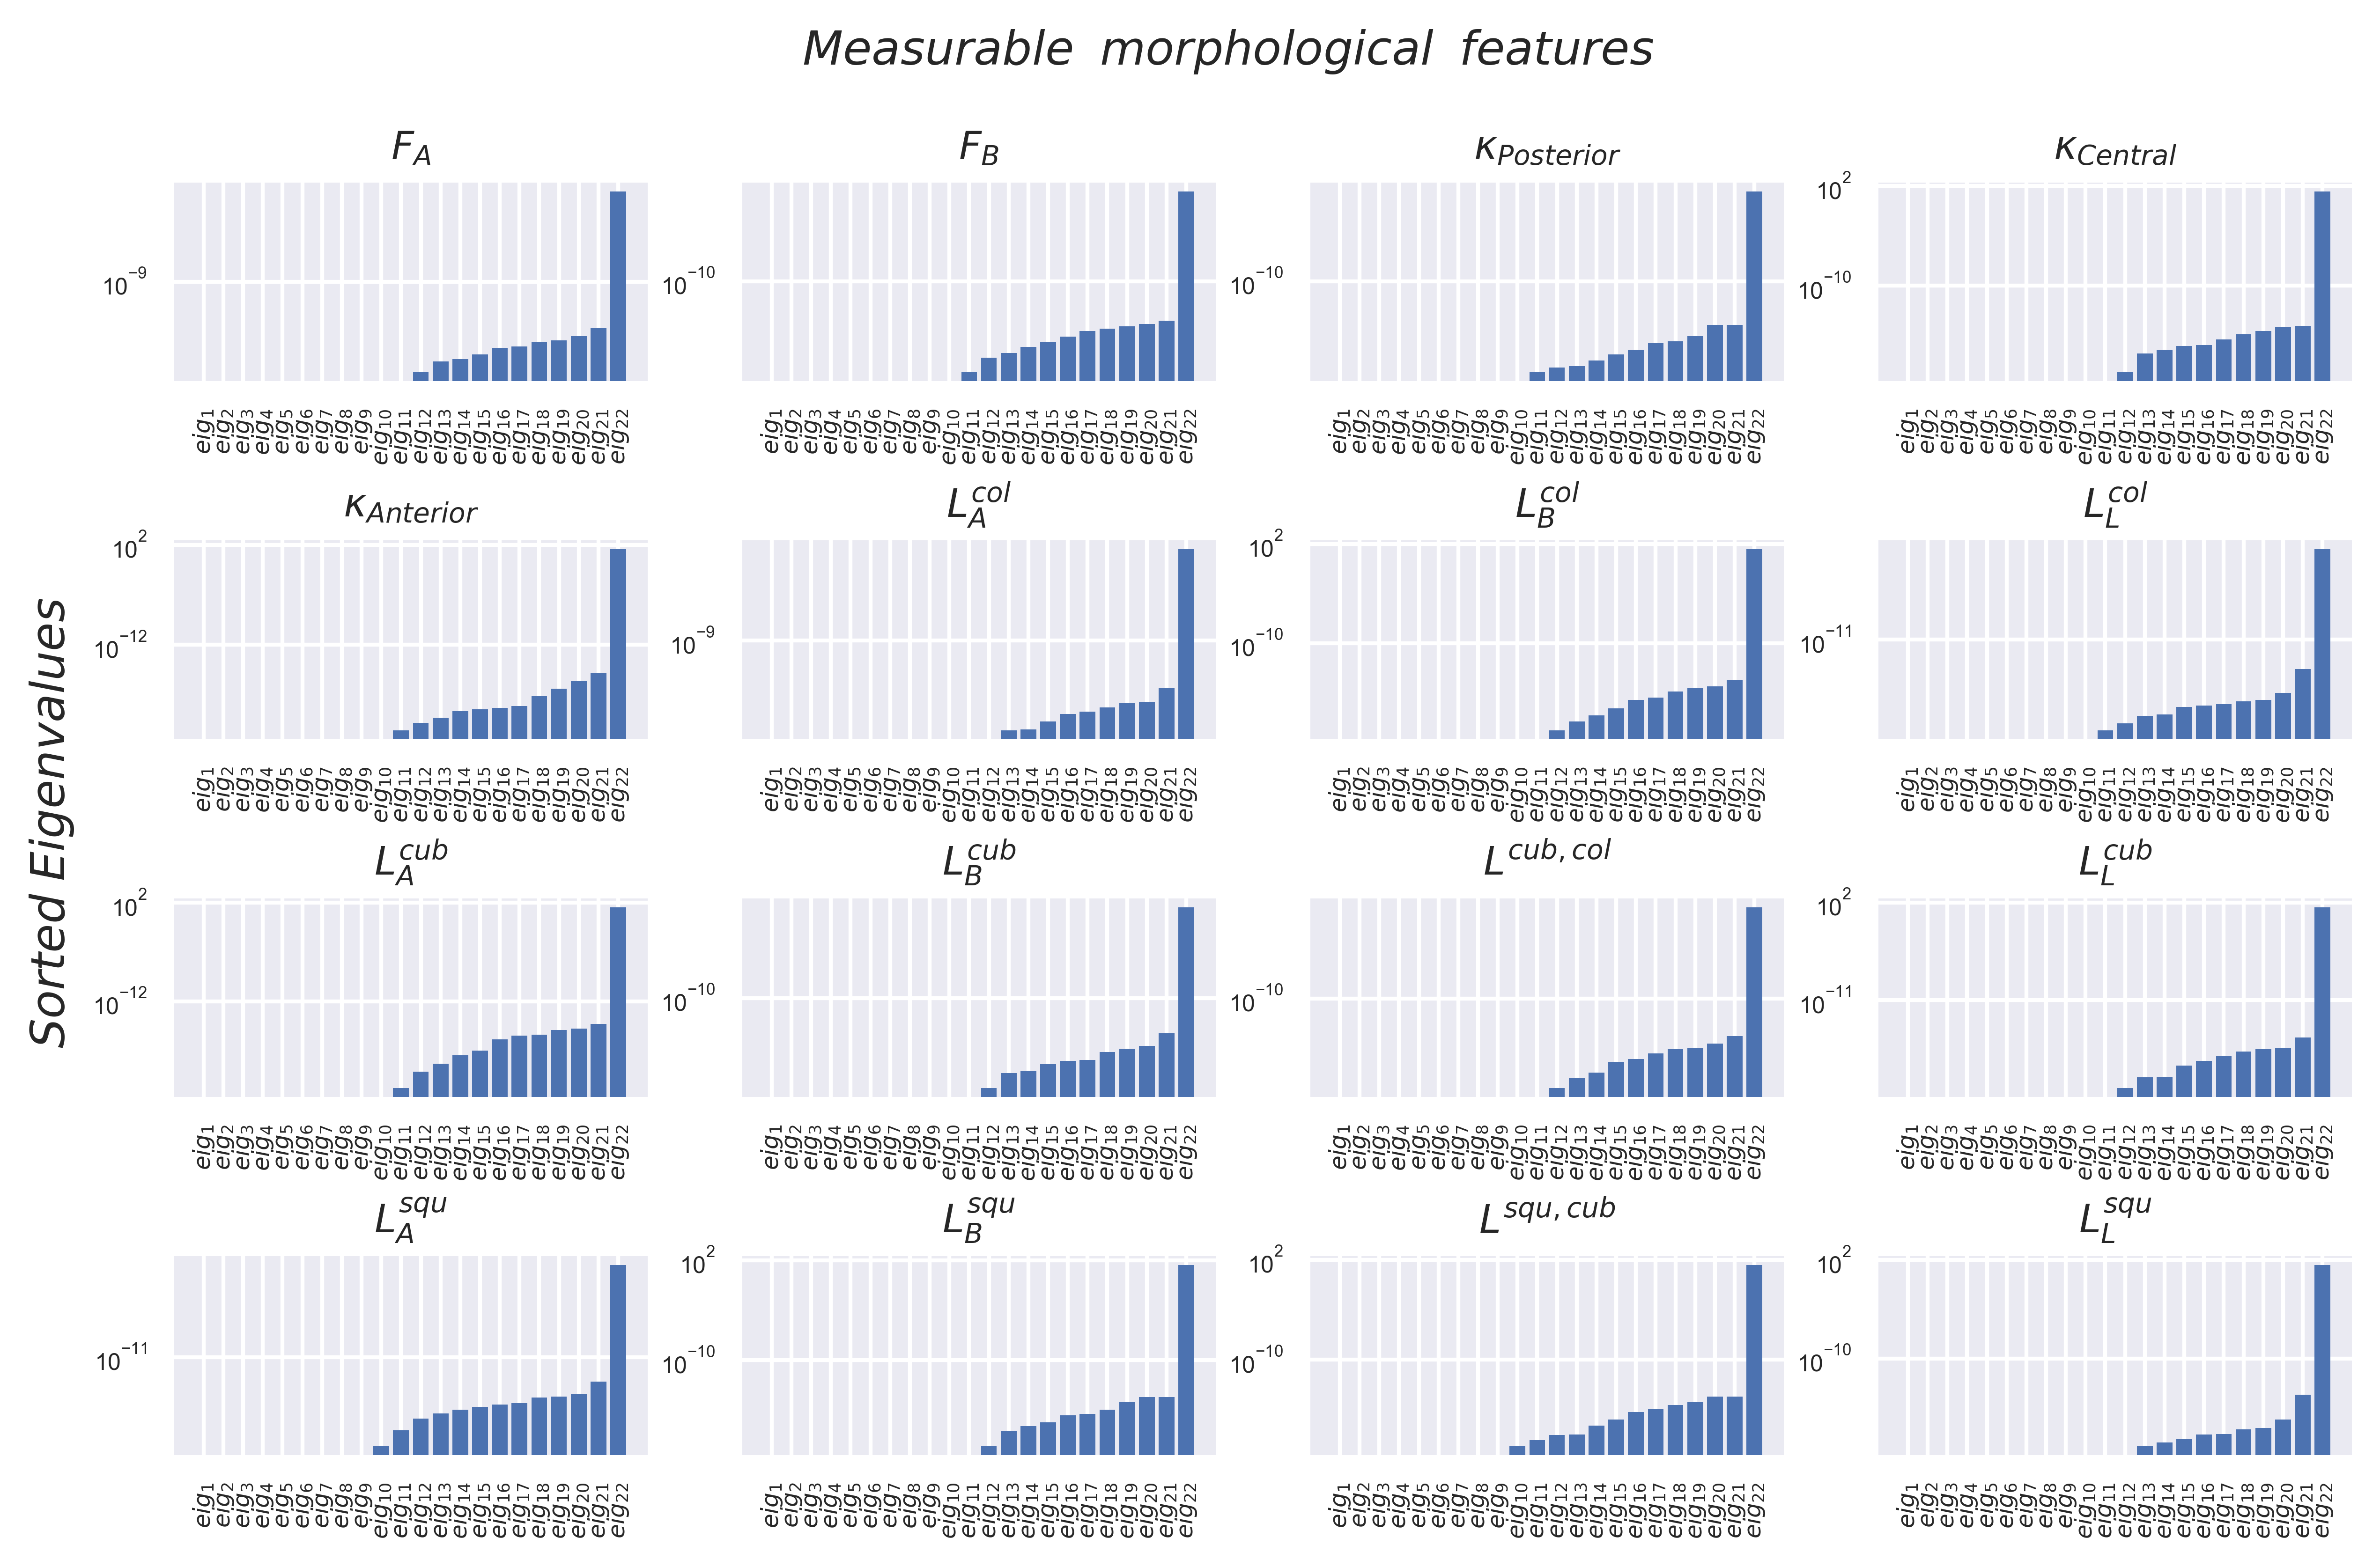

In [7]:
# Defining eigenvalue labels
eig_labels = ('$eig_{1}$', '$eig_{2}$', '$eig_{3}$', '$eig_{4}$', '$eig_{5}$', '$eig_{6}$', '$eig_{7}$',
              '$eig_{8}$', '$eig_{9}$', '$eig_{10}$', '$eig_{11}$', '$eig_{12}$', '$eig_{13}$', '$eig_{14}$',
              '$eig_{15}$', '$eig_{16}$', '$eig_{17}$', '$eig_{18}$', '$eig_{19}$', '$eig_{20}$', '$eig_{21}$', '$eig_{22}$')
# Defining the figure size and type
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(10, 6), dpi=600)
# Define the position of bars within the x axis. Equals to numbers of parameters
x_pos = np.arange(len(params_lhs))

# Iterating over eigenvalues of each 
for i in range(16):
        plt.subplot(4, 4, i+1)
        # Plotting the eigenvalues against the define position in x axis
        plt.bar(y_pos, fim_eig_real[i,:])
        plt.xticks(x_pos, eig_labels)
        # Rotating the label of xticks by 90 degrees
        plt.xticks(rotation = 90)
        # Defining the tick label sizes for x and y axis
        plt.xticks(fontsize=6) 
        plt.yticks(fontsize=6)
        # Turning logscale on in y direction
        plt.yscale('log')
        plt.title(x_label[i], fontsize=10)
           
# Adjusting vertical spacing between subplots            
plt.subplots_adjust(hspace=0.8)
# Defining the x and y labels of plot
fig.text(0.073, 0.5, '$Sorted$ $Eigenvalues$', va='center', rotation='vertical')
fig.text(0.5, 0.95, '$Measurable$  $morphological$  $features$', ha='center')

__Figure 4: Plotting eigenvalues of individual Fisher Information Matrices__ *Note: The eigenvalues are sorted and plotted in ascending order.*

### 3.2 Plotting eigenvectors corresponding to the largest eigenvalue of FIM for each morphological features.

Text(0.5,-46.0667,'$Model$ $Parameters$')

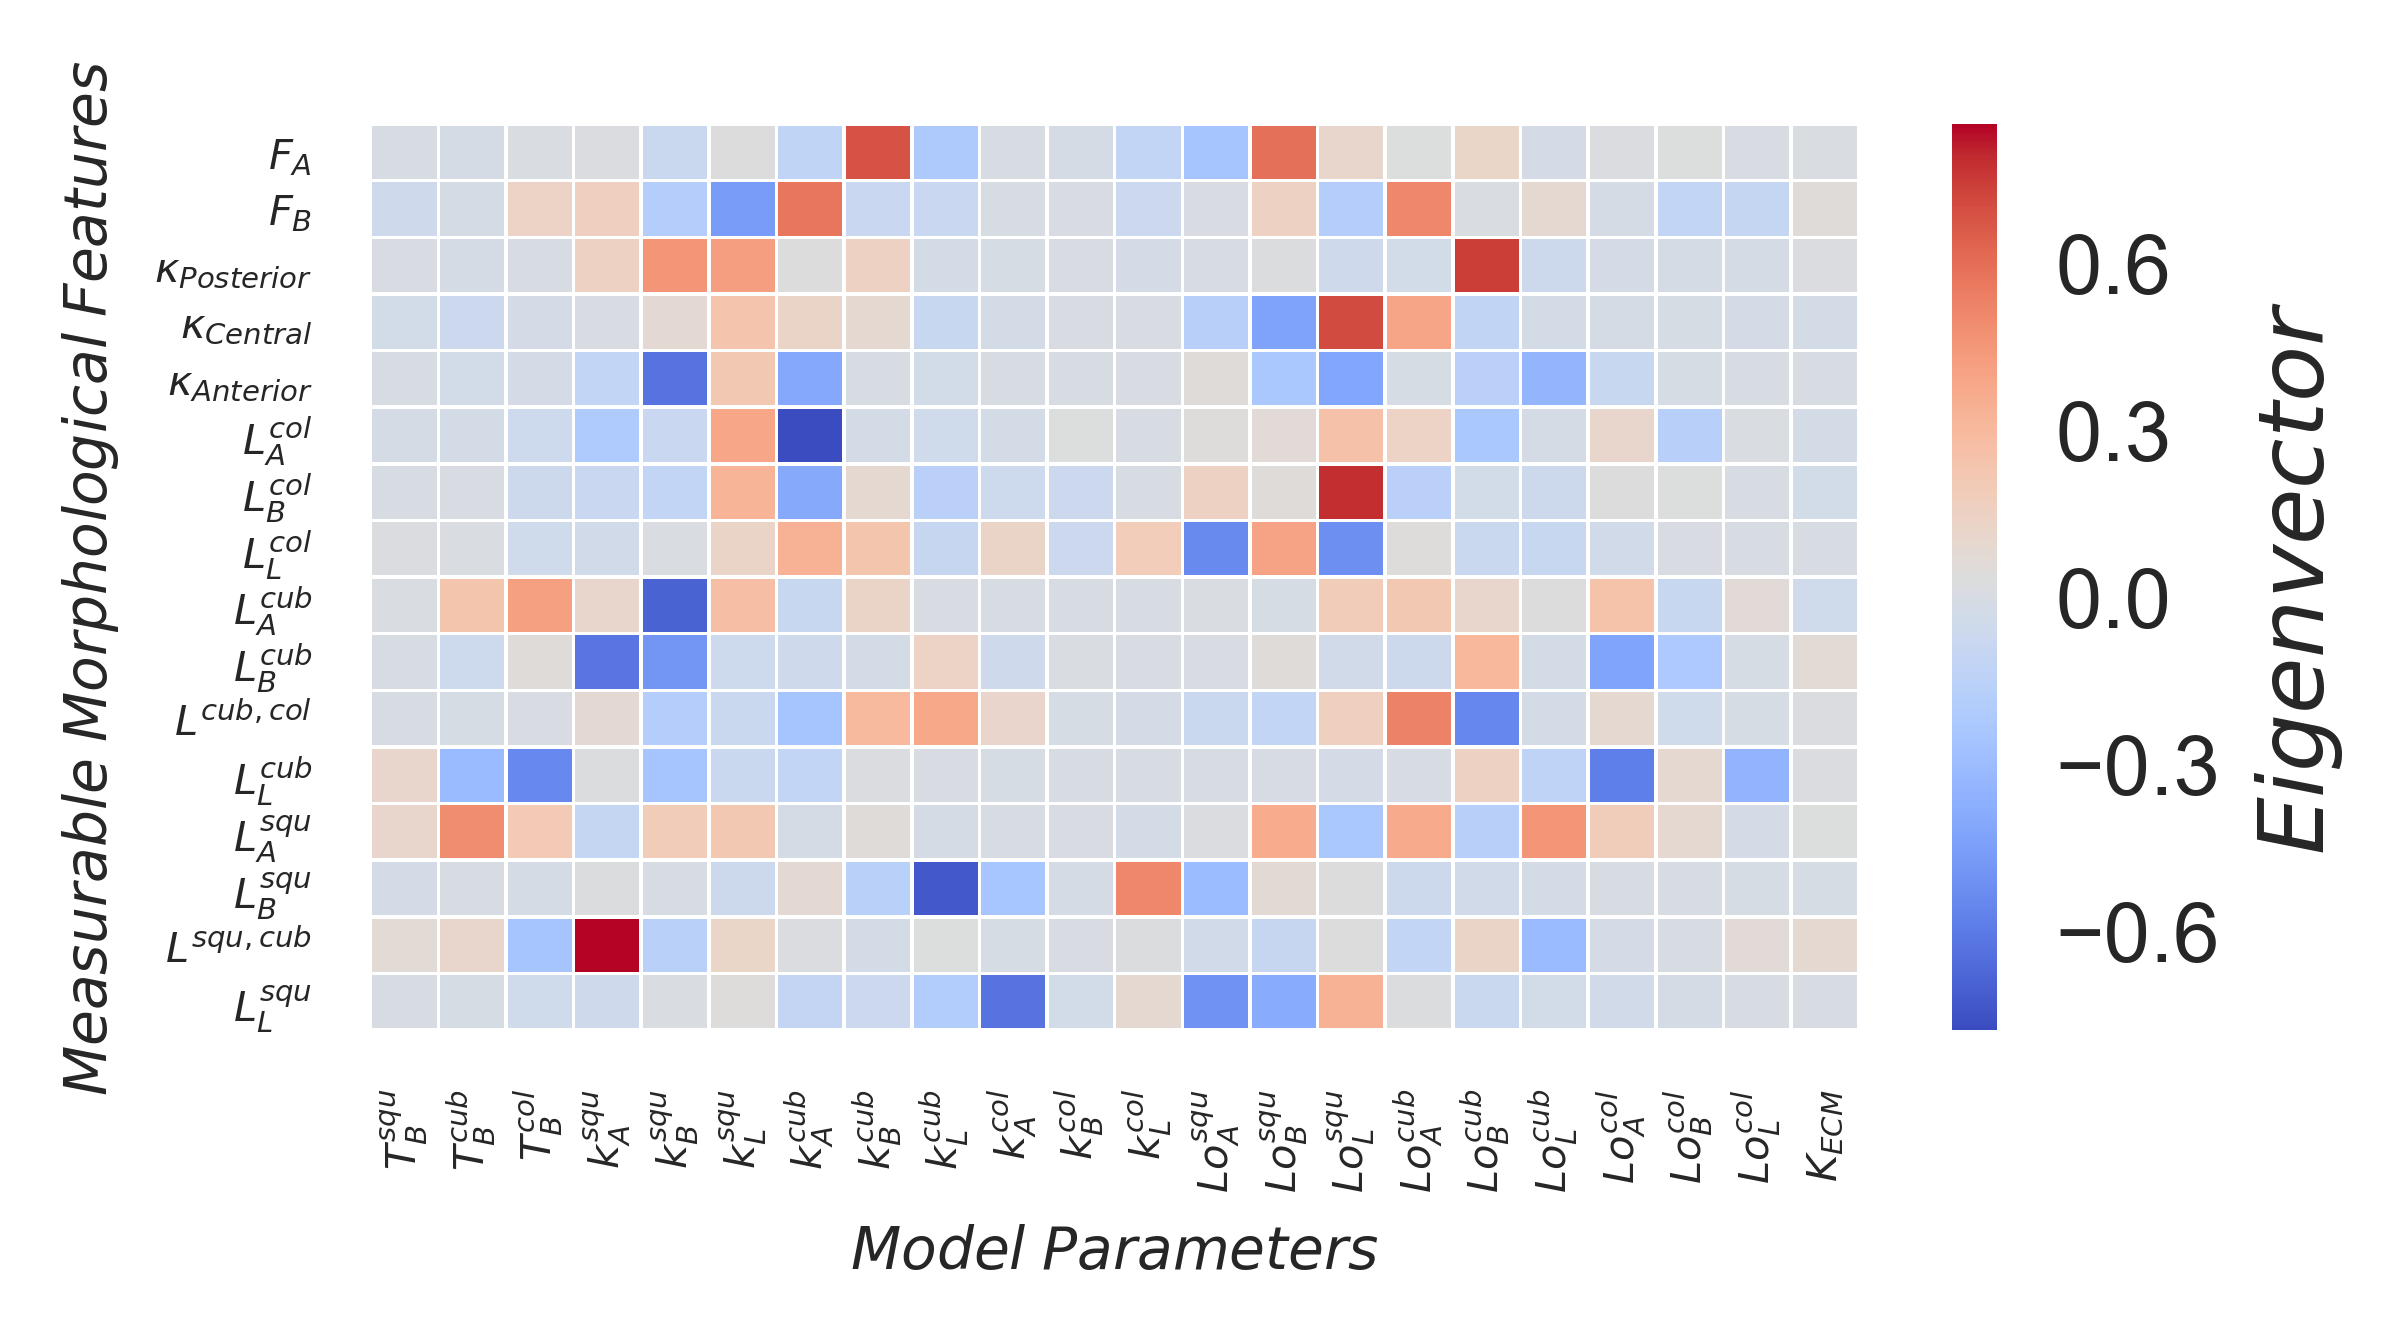

In [9]:
# Defining the number of parameters and number of features in the study
num_param = 22
num_feature = 16

# Starting the iteration counter
k = 0
# Initializing the matrix for Storing eigenvectors corresponding to the maximum eigenvalues
fim_evec_max_eval = np.zeros((num_feature,num_param))

# Loop over all the jacobians of inmdividual features
for i in range(4):
    for j in range(4):
        # Fetching jacobian of individual features from the master sensitivity matrix
        jacobian_feature = np.reshape(sens_master[:,k],(num_param,1))
        # calculate fischer information matrix
        # Note: Scaling wrt variance of jacobian has been done
        fim_feature = np.matmul(jacobian_feature,jacobian_feature.transpose())/((np.std(jacobian_feature))**2)
        # Calculate eigenvalue and eigenvectors of the symmetric matrix using eigh
        fim_eigvalue, fim_eigenvector = np.linalg.eigh(fim_feature)
        # Since the eigenvalue is sorted. Selecting the last eigenvector corresponding to th eg reatest eigenvalue 
        fim_evec_max_eval[k,:] = np.reshape((fim_eigenvector[num_param-1,:]),(1,num_param))
        # Managing iter counter
        k = k + 1
        
""" Plotting the eigenvector matrix corresponding to maximum eigenvalues """
# Importing seaborn for visualization of the sensitivity array
import seaborn as sns
# Defining labels of features and parameters
feature_label = ('$F_{A}$','$F_{B}$')+('$\kappa_{Posterior}$','$\kappa_{Central}$','$\kappa_{Anterior}$')+ edge_length_labels
params_lhs = ('$T^{squ}_{B}$','$T^{cub}_{B}$','$T^{col}_{B}$','$k^{squ}_{A}$','$k^{squ}_{B}$','$k^{squ}_{L}$','$k^{cub}_{A}$','$k^{cub}_{B}$','$k^{cub}_{L}$','$k^{col}_{A}$','$k^{col}_{B}$','$k^{col}_{L}$','$Lo^{squ}_{A}$','$Lo^{squ}_{B}$','$Lo^{squ}_{L}$','$Lo^{cub}_{A}$','$Lo^{cub}_{B}$','$Lo^{cub}_{L}$','$Lo^{col}_{A}$','$Lo^{col}_{B}$','$Lo^{col}_{L}$','$K_{ECM}$')
# Defining the resolution of the figure
sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
# Defining the size of figure
sns.set(rc={'figure.figsize':(4,2)})
# Using seaborn to plot visualize the array as a heatmap
ax = sns.heatmap((fim_evec_max_eval), xticklabels = params_lhs, yticklabels = feature_label, linewidths=.3, cmap="coolwarm", cbar_kws={'label': '$Eigenvector$'})
# Labelling the axes
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 5)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
ax.set_ylabel('$Measurable$ $Morphological$ $Features$', fontsize=7)
ax.set_xlabel('$Model$ $Parameters$', fontsize=7)

__Figure 5: Plotting eigenvalues (rows) corresponding to maximum eigenvalue of the approximated FIM of different geometric features (column)__ *Note: $F_{A}$ and $F_{B}$ have to disregarded of this analysis.*